In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import gensim.downloader
from gensim.models import Word2Vec
import nltk

In [2]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:22<00:00,  5.69it/s]


In [3]:
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"])

[{'role': 'user',
  'text': 'Load a CSV file into a Pandas in Python. The file is named '
          "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
          "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
          "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
          "'Health Metrics'. \n"},
 {'role': 'assistant',
  'text': 'You can load a CSV file into a Pandas DataFrame in Python using the '
          "pandas.read_csv() function. Here's how you can do it for your "
          'specific CSV file:pythonCopy codeimport pandas as pd\n'
          '\n'
          '# Specify the file path\n'
          "file_path = 'cs412_hw1_dataset.csv'\n"
          '\n'
          '# Load the CSV file into a Pandas DataFrame\n'
          'df = pd.read_csv(file_path)\n'
          '\n'
          '# Display the first few rows of the DataFrame to verify the data '
          'has been loaded\n'
          'print(df.head())\n'
          "This code assume

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [4]:
prompts = []
characters_to_remove = ["\n","`",'\\']
code2prompts = defaultdict(list)
code2prompts_str = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
          for element in characters_to_remove: #Removal of such characters
            conv["text"] = conv["text"].replace(element,"")
          prompts.append(conv["text"])
          user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [6]:
questions = [ #Removed a question here wasn't leading to points also removed some characters!
#####################
    """Load training dataset
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset and Preprocessing
Understanding the Dataset:
Find the shape of the dataset (number of samples and number of attributes). (Hint: You can use the **shape** function)
Display variable names (both dependent and independent).
Display the summary of the dataset. (Hint: You can use the **info** function)
Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing:
Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**
Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X and y, split data

Shuffle the dataset.
Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations

Correlations of features with health
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

Feature Selection
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

Hypothetical Driver Features
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

""",
#####################
"""Tune Hyperparameters
Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values.
Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)*
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen
Re-train model with the hyperparameters you have chosen in part 5).
Plot the tree you have trained.
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set
Predict the labels of testing data using the tree you have trained in step 6.
Report the classification accuracy.
Plot & investigate the confusion matrix. Fill the following blanks.
The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split"""
#####################
]
for item in questions:
  for element in characters_to_remove: #Removal of such characters
    item = item.replace(element,"")


In [7]:
#Train A Word2Vec Model
nltk.download('punkt')

# Tokenize sentences and create a flat list of sentences
sentence_load = []
test_list = list(code2prompts.values())
test_list.append(questions)
for sentences in test_list:
    for sentence in sentences:
        # Tokenize each sentence
        tokenized_sentence = nltk.word_tokenize(sentence)
        sentence_load.append(tokenized_sentence)

# Training the Word2Vec model
vector_size = 600
window = 5
min_count = 2

hw_grading_word2vec_model = Word2Vec(
    sentences=sentence_load,
    vector_size=vector_size,
    window=window,
    min_count= min_count,
    workers=10
)
hw_grading_word2vec_model
#Train A Word2Vec Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
code2prompts

defaultdict(list,
            {'0031c86e-81f4-4eef-9e0e-28037abf9883': ["Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. ",
              'Provide Python code to understand a dataset using Pandas. Find the shape of the dataset, display variable names, display a summary of the dataset with the info() function, and show the first 5 rows using the head() function.',
              "You will preprocess the data now1. Check for missing values and handle them by either dropping or filling them with the most common values. Ensure that there is enough data for training the model. You can only use %80 data for training and %20 for testing2. Encode labels with mappings using the map function. Mapping names:    - sex_map = {'female': 1, 'male': 0}   - island_map = {'Biscoe': 1, 'Dr

In [9]:
def vectorize_sentence(prompt): ## Each sentence of prompt being vectorized
  user_vector_list = list([])
  for sentence in prompt:
    tokens = sentence.split()
    word_vectors = [hw_grading_word2vec_model.wv[word] for word in tokens if word in hw_grading_word2vec_model.wv]
    if not word_vectors:
      user_vector_list.append(np.zeros(hw_grading_word2vec_model.vector_size))
      continue
    user_vector_list.append(np.mean(word_vectors, axis=0))
  return user_vector_list

code2prompts_word2vec = dict()
for code, user_prompts in code2prompts.items():
  if len(user_prompts) == 0:
      print(code+".html")
      continue
  prompts_word2Vec = pd.DataFrame(vectorize_sentence(user_prompts))
  code2prompts_word2vec[code] = prompts_word2Vec

questions_word2Vec = pd.DataFrame(vectorize_sentence(questions)) #Questions vectorized


139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [10]:
code2prompts_word2vec["7ac3f7a5-bdbb-470c-a1b3-03da5887a408"]

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.248736,-0.041814,-0.116703,0.001742,0.201583,0.024549,0.066810,0.235133,0.124908,0.008932,...,-0.212245,-0.175540,0.077646,-0.147176,0.088689,0.029196,0.097385,-0.116305,-0.039358,-0.175146
1,0.601798,-0.100383,-0.154257,0.004208,0.418107,-0.192983,-0.034868,0.378684,0.191533,-0.130962,...,-0.068141,-0.293211,0.017133,-0.240231,0.361702,0.258964,0.176688,-0.154677,0.021358,-0.079561
2,0.263292,0.070734,0.067603,-0.263888,0.351527,-0.051841,0.170320,0.529186,-0.121837,0.352658,...,-0.495844,-0.063934,0.010375,0.052728,0.054243,0.146758,0.023970,-0.254055,-0.089901,-0.059809
3,0.190138,-0.025335,0.183299,0.039022,0.074814,-0.081790,0.321245,0.621548,-0.117535,0.146594,...,-0.210402,-0.116759,0.013418,-0.066816,0.179594,0.177751,-0.099653,-0.447020,-0.110463,-0.222594
4,0.512423,-0.067278,-0.237760,0.044664,0.365782,-0.087679,-0.026794,0.393980,0.176356,-0.084504,...,-0.051312,-0.246026,0.026628,-0.149078,0.380843,0.303481,0.185884,-0.215456,-0.123034,-0.168066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.423879,0.022528,-0.346912,-0.118263,0.355486,0.106500,-0.033509,0.352100,0.114173,-0.271576,...,-0.023699,-0.082745,0.028448,-0.151916,-0.001838,0.209977,0.301660,-0.095155,-0.097290,-0.069319
60,0.580885,-0.029739,-0.077922,0.147550,0.003974,-0.138226,0.335628,0.504278,-0.162434,-0.076144,...,-0.027964,0.103483,0.112141,-0.048548,0.362127,0.230648,-0.059793,0.210128,0.063523,-0.078637
61,0.536233,-0.148980,-0.031506,-0.118731,0.283376,-0.179317,0.414511,0.711358,-0.136852,-0.128622,...,-0.256012,-0.085382,-0.039850,-0.184878,0.346295,0.263473,-0.006442,-0.042380,-0.083724,-0.119670
62,0.443223,-0.156621,-0.003030,-0.137893,0.300117,0.039874,-0.092448,0.487006,0.081200,-0.022852,...,-0.265827,-0.105072,0.175916,-0.076747,0.206606,0.208695,0.113116,-0.054924,-0.058921,-0.104268


In [11]:
questions_word2Vec

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.314319,-0.098530,-0.133045,-0.044573,0.278634,0.052376,-0.096437,0.327040,0.068675,-0.004396,...,-0.129394,-0.137849,0.037532,-0.104757,0.126390,0.153423,0.194180,-0.184730,-0.178032,-0.139536
1,0.362523,-0.003893,-0.158374,0.004281,0.303510,0.024496,0.065505,0.332526,0.112450,-0.022607,...,-0.199510,-0.152277,0.004431,-0.143185,0.201976,0.331969,0.096340,-0.237059,-0.003598,-0.208320
2,0.187899,-0.002369,0.048494,-0.079858,0.225757,-0.043678,0.010418,0.414765,-0.072915,0.125321,...,-0.246677,-0.027354,0.091953,0.078923,-0.031995,-0.013015,0.043047,-0.137386,-0.050967,-0.011183
3,0.045844,-0.015289,0.044434,-0.138496,0.122990,0.029187,0.082188,0.169465,-0.082253,0.141638,...,-0.363218,-0.083305,-0.063186,-0.127221,0.060361,-0.095164,-0.082496,-0.137443,0.181984,-0.171937
4,0.373588,-0.016395,-0.210701,0.090735,0.153349,0.052047,0.138661,0.411517,-0.022638,-0.149820,...,-0.042752,-0.142737,0.035565,-0.155720,0.272902,0.284387,0.008194,-0.185410,0.123765,-0.182142
5,0.296895,0.009987,-0.352179,-0.053237,0.216115,0.169022,0.113174,0.437808,0.060270,-0.181271,...,-0.087060,-0.052842,-0.016354,-0.140042,0.208886,0.284971,0.167123,-0.238291,-0.082247,-0.300404
6,0.346625,-0.028189,-0.162403,0.003750,0.190979,0.014676,0.106106,0.455652,0.018306,-0.097277,...,-0.064638,-0.038299,0.101845,-0.104826,0.202530,0.220209,0.127004,-0.103445,-0.115380,-0.160305
7,0.483992,-0.242418,0.000462,-0.202041,0.291011,0.027494,-0.158967,0.717010,0.077844,-0.045991,...,-0.365565,-0.140306,0.225967,-0.080298,0.291050,0.107954,0.118014,-0.060496,-0.085055,-0.246567


In [12]:
code2cosine_word2vec = dict()
for code, user_prompts_word2vec in code2prompts_word2vec.items():
    code2cosine_word2vec[code] = pd.DataFrame(cosine_similarity(questions_word2Vec,user_prompts_word2vec))

In [13]:
code2questionmapping_word2vec = dict()
for code, cosine_scores in code2cosine_word2vec.items():
    code2questionmapping_word2vec[code] = code2cosine_word2vec[code].max(axis=1).tolist()


question_mapping_scores_word2vec = pd.DataFrame(code2questionmapping_word2vec).T
question_mapping_scores_word2vec.reset_index(inplace=True)
question_mapping_scores_word2vec.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_word2vec.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores_word2vec

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.952371,0.945864,0.883484,0.958277,0.937714,0.905319,0.927563,0.844046
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.952325,0.954226,0.987688,0.955031,0.999641,0.968577,0.930307,0.984479
2,041f950b-c013-409a-a642-cffff60b9d4b,0.941229,0.961824,0.784295,0.938619,0.896983,0.916995,0.962728,0.787581
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.864364,0.883267,0.849326,0.897971,0.929658,0.866316,0.922218,0.965559
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.937059,0.948438,0.961707,0.954421,0.986126,0.968431,0.990579,0.977873
...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.932855,0.942878,0.835466,0.897609,0.924785,0.999135,0.998591,0.988644
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.910750,0.949540,0.996495,0.991519,0.990321,0.937899,0.992642,0.972996
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.981714,0.999414,0.996618,0.999557,0.999442,0.998410,0.999209,0.980633
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.975622,0.993806,0.953104,0.999630,0.984426,1.000000,1.000000,0.942058


In [14]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [15]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF

,00000,000000,000000diet,000000flipper_length_mm,000000life_stage,000000name,000000year,000196,000196diet,000282island,...,yx,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [17]:
print(code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape)
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"]

(86, 6495)


,00000,000000,000000diet,000000flipper_length_mm,000000life_stage,000000name,000000year,000196,000196diet,000282island,...,yx,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [19]:
questions[0]

'Load training dataset\n    *  Read the .csv file with the pandas library\n'

In [29]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores_tf_idf = pd.DataFrame(code2questionmapping).T
question_mapping_scores_tf_idf.reset_index(inplace=True)
question_mapping_scores_tf_idf.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_tf_idf.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores_tf_idf

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.304079,0.536070,0.368903,0.504798,0.577103,0.181440,0.188972,0.217575
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.823039,0.786561,0.891001,0.678520,0.972643,0.790169,0.560439,0.609047
2,041f950b-c013-409a-a642-cffff60b9d4b,0.260152,0.611201,0.326975,0.649491,0.431308,0.509783,0.513320,0.287194
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.122250,0.270359,0.320293,0.367270,0.320677,0.207892,0.286513,0.456046
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.595014,0.797634,0.646773,0.738703,0.864109,0.623336,0.892093,0.573190
...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.153030,0.298647,0.215979,0.157421,0.516581,0.927496,0.765982,0.750481
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.123868,0.277965,0.959469,0.857600,0.859482,0.284532,0.853966,0.619669
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.938918,0.972892,0.930543,0.992783,0.956679,0.840114,0.837490,0.559604
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,1.000000,0.977436,0.703321,0.949386,0.849035,0.927496,0.915792,0.745384


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [62]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy","how"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [63]:
df_tf_idf = pd.DataFrame(code2features).T
df_word2vec = pd.DataFrame(code2features).T
df_word2vec.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,18.850913


In [64]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


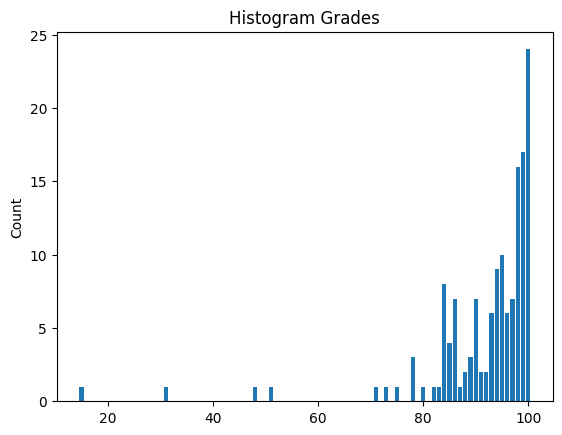

In [65]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [66]:
df_tf_idf.reset_index(inplace=True, drop=False)
df_tf_idf.rename(columns={"index": "code"}, inplace=True)

df_word2vec.reset_index(inplace=True, drop=False)
df_word2vec.rename(columns={"index": "code"}, inplace=True)

df_tf_idf.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,18.850913


In [67]:
df_tf_idf = pd.merge(df_tf_idf, question_mapping_scores_tf_idf, on="code", how="left")
df_word2vec = pd.merge(df_word2vec, question_mapping_scores_word2vec, on="code", how="left")
df_word2vec.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,212.206370,0.952371,0.945864,0.883484,0.958277,0.937714,0.905319,0.927563,0.844046
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,113.633582,0.952325,0.954226,0.987688,0.955031,0.999641,0.968577,0.930307,0.984479
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,17.187601,0.941229,0.961824,0.784295,0.938619,0.896983,0.916995,0.962728,0.787581
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,107.092566,0.864364,0.883267,0.849326,0.897971,0.929658,0.866316,0.922218,0.965559
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,18.850913,0.937059,0.948438,0.961707,0.954421,0.986126,0.968431,0.990579,0.977873


#### Merging scores with features

In [72]:
temp_df_tf_idf = pd.merge(df_tf_idf, scores, on='code', how="left")
temp_df_tf_idf.dropna(inplace=True)
temp_df_tf_idf.drop_duplicates("code",inplace=True, keep="first")

temp_df_word2vec = pd.merge(df_word2vec, scores, on='code', how="left")
temp_df_word2vec.dropna(inplace=True)
temp_df_word2vec.drop_duplicates("code",inplace=True, keep="first")



temp_df_tf_idf.head()
temp_df_word2vec.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,212.206370,0.952371,0.945864,0.883484,0.958277,0.937714,0.905319,0.927563,0.844046,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,113.633582,0.952325,0.954226,0.987688,0.955031,0.999641,0.968577,0.930307,0.984479,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,17.187601,0.941229,0.961824,0.784295,0.938619,0.896983,0.916995,0.962728,0.787581,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,107.092566,0.864364,0.883267,0.849326,0.897971,0.929658,0.866316,0.922218,0.965559,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,18.850913,0.937059,0.948438,0.961707,0.954421,0.986126,0.968431,0.990579,0.977873,100.0


In [73]:
X_tf_idf = temp_df_tf_idf[temp_df_tf_idf.columns[1:-1]].to_numpy()
y_tf_idf = temp_df_tf_idf["grade"].to_numpy()

X_word2vec = temp_df_word2vec[temp_df_word2vec.columns[1:-1]].to_numpy()
y_word2vec = temp_df_word2vec["grade"].to_numpy()


print(X_tf_idf.shape, y_tf_idf.shape)
print(X_word2vec.shape, y_word2vec.shape)

(122, 17) (122,)
(122, 17) (122,)


#### Train/Test split

In [77]:
X_train_tf_idf, X_test_tf_idf, y_train_tf_idf, y_test_tf_idf = train_test_split(X_tf_idf, y_tf_idf, test_size=0.2, random_state=42)
print("Train set size:", len(X_train_tf_idf))
print("Test set size:", len(X_test_tf_idf))

X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X_word2vec, y_word2vec, test_size=0.2, random_state=42)
print("Train set size:", len(X_train_word2vec))
print("Test set size:", len(X_test_word2vec))

Train set size: 97
Test set size: 25
Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing

In [78]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train_tf_idf, y_train_tf_idf)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [ ]:
extracted_MSEs = regressor.tree_.impurity
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

In [81]:
# Plotting the Tree
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df_tf_idf.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

In [82]:
# Prediction
y_train_pred = regressor.predict(X_train_tf_idf)
y_test_pred = regressor.predict(X_test_tf_idf)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train_tf_idf,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test_tf_idf,y_test_pred))

print("R2 Train:", r2_score(y_train_tf_idf,y_train_pred))
print("R2 TEST:", r2_score(y_test_tf_idf,y_test_pred))


MSE Train: 2.6184830633284246
MSE TEST: 113.04108979591837
R2 Train: 0.9839770066096497
R2 TEST: -0.0069076350718151325
